In [2]:
import random
import pandas as pd
from matplotlib import pyplot as plt
import math
from math import sin, cos, sqrt, atan2, radians
import scipy.stats as sc
from sklearn.model_selection import train_test_split, cross_val_score #set splitting and validation
from sklearn.linear_model import LinearRegression

In [4]:
df = pd.read_csv("/Users/sriramreddy/Downloads/DSF/HW2/all/train.csv",nrows=11000000)
tf = pd.read_csv("/Users/sriramreddy/Downloads/DSF/HW2/all/test.csv")
# df.describe()
df['Date'], df['Time'],df['Zone'] = df['pickup_datetime'].str.split(' ', 2).str
df=df.drop(['pickup_datetime'],axis=1)
df = df.drop(df[df['passenger_count']>10].index, axis = 0)
df = df.drop(df[df['passenger_count']==0].index, axis = 0)
df['Euclidean_distance']=((df.pickup_longitude - df.dropoff_longitude)**2 +(df.pickup_latitude - df.dropoff_latitude)**2)**0.5

from math import sin, cos, sqrt, atan2, radians
def haversine(df):
    R = 3959.0
    for i,row in df.iterrows():
        lat1 = radians(row['pickup_latitude'])
        lon1 = radians(row['pickup_longitude'])
        lat2 = radians(row['dropoff_latitude'])
        lon2 = radians(row['dropoff_longitude'])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = R * c
        df.at[i,'distance'] = distance

df = df.drop(df[df['fare_amount']>200].index, axis = 0)
df = df.drop(df[df['fare_amount']<1].index, axis = 0)
df = df.drop(((df[df['dropoff_latitude']<-90])|(df[df['dropoff_latitude']>90])).index, axis=0)
df = df.drop(((df[df['dropoff_longitude']<-180])|(df[df['dropoff_longitude']>180])).index, axis=0)
df=df[df.Euclidean_distance != 0]
df['Hour'], df['Min'], df['Sec'] = df['Time'].str.split(':', 2).str
# I have checked the co-ordinates of the New York city and I have taken extreme points.
df = df[df['pickup_longitude'] < -73.699215]
df = df[df['pickup_longitude'] > -74.257159]
df = df[(df['pickup_latitude'] > 40.495992) & (df['pickup_latitude'] < 40.916)]
df = df[df['dropoff_longitude'] < -73.699215]
df = df[df['dropoff_longitude'] > -74.257159]
df = df[(df['dropoff_latitude'] > 40.495992) & (df['dropoff_latitude'] < 40.916)]
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['weekday'] = df.Date.dt.weekday
df['Month']=df.Date.dt.month
df['Year']=df.Date.dt.year
df=df.drop(['Date'],axis=1)
df=df.drop(['Zone'],axis=1)
df.drop(df.columns[0], axis=1)
df=df.drop(['Time'],axis=1)
haversine(df)
df=df.dropna(axis=0)
df.Hour = df.Hour.astype(float)
df.Min = df.Min.astype(float)
df.Sec = df.Sec.astype(float)
pd.to_numeric(df.Hour, errors='coerce')
pd.to_numeric(df.Min, errors='coerce')
pd.to_numeric(df.Sec, errors='coerce')
df['Hour_rate'] = ((df.Hour + (df.Min*60.0 + df.Sec)/3600))
#pre-processing done
import scipy.stats as sc
A=sc.pearsonr(df.Euclidean_distance, df.fare_amount)
B=sc.pearsonr(df.Hour_rate, df.distance)
C=sc.pearsonr(df.Hour_rate, df.fare_amount)
D= sc.pearsonr(df.distance, df.fare_amount)
print("pearson_correlation of entire data",A,B,C,D)

# Test data cleaning
tf = pd.read_csv("/Users/sriramreddy/Downloads/DSF/HW2/all/test.csv")
tf['Date'], tf['Time'],tf['Zone'] = tf['pickup_datetime'].str.split(' ', 2).str
tf=tf.drop(['pickup_datetime'],axis=1)
tf['Euclidean_distance']=((tf.pickup_longitude - tf.dropoff_longitude)**2 +(tf.pickup_latitude - tf.dropoff_latitude)**2)**0.5
from math import sin, cos, sqrt, atan2, radians
def haversine(tf):
    R = 3959.0
    for i,row in tf.iterrows():
        lat1 = radians(row['pickup_latitude'])
        lon1 = radians(row['pickup_longitude'])
        lat2 = radians(row['dropoff_latitude'])
        lon2 = radians(row['dropoff_longitude'])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = R * c
        tf.at[i,'distance'] = distance
tf['Hour'], tf['Min'], tf['Sec'] = tf['Time'].str.split(':', 2).str
tf['Date'] = pd.to_datetime(tf['Date'], format='%Y-%m-%d')
tf['weekday'] = tf.Date.dt.weekday
tf['Month']=tf.Date.dt.month
tf['Year']=tf.Date.dt.year
tf=tf.drop(['Date'],axis=1)
tf=tf.drop(['Zone'],axis=1)
tf.drop(tf.columns[0], axis=1)
tf=tf.drop(['Time'],axis=1)
# tf=tf.drop(['key'])--------------------This drops the first column
tf=tf.drop(tf.columns[0], axis=1)
haversine(tf)
tf.Hour = tf.Hour.astype(float)
tf.Min = tf.Min.astype(float)
tf.Sec = tf.Sec.astype(float)
pd.to_numeric(tf.Hour, errors='coerce')
pd.to_numeric(tf.Min, errors='coerce')
pd.to_numeric(tf.Sec, errors='coerce')
tf['Hour_rate'] = ((tf.Hour + (tf.Min*60.0 + tf.Sec)/3600))
X = df.drop(['key','fare_amount'],axis=1)
y = df['fare_amount']


import xgboost as xgb 
X = df.drop(['key','fare_amount'],axis=1)
y = df['fare_amount']
X_train = xgb.DMatrix(X, label=y)
X_test = xgb.DMatrix(tf)
params = {'max_depth':7,
          'eta':1,
          'silent':1,
          'objective':'reg:linear',
          'eval_metric':'rmse',
          'learning_rate':0.05
         }
num_rounds = 60
xb = xgb.train(params, X_train, num_rounds)
y_pred_xgb = xb.predict(X_test)
print(y_pred_xgb)

# I have taken referrence from the following link:
# https://www.kaggle.com/madhurisivalenka/cleansing-eda-modelling-lgbm-xgboost-starters/comments


submission = pd.read_csv('/Users/sriramreddy/Downloads/DSF/HW2/all/sample_submission.csv')
submission['fare_amount'] = y_pred_xgb
submission.to_csv('/Users/sriramreddy/Downloads/DSF/HW2/all/submission_xgb_first_11.csv', index=False)

pearson_correlation of entire data (0.015583777034493661, 0.0) (-0.007416771899850075, 6.813146209097224e-129) (-0.017561136590543064, 0.0) (0.2237917755061497, 0.0)
[17:37:59] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[ 9.797076  10.187675   4.7528615 ... 52.466763  20.51092    6.978396 ]


In [5]:
df.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Euclidean_distance,Hour,Min,Sec,weekday,Month,Year,distance,Hour_rate
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0.009436,17.0,26.0,21.0,0,6,2009,0.640527,17.439167
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,0.079696,16.0,52.0,16.0,1,1,2010,5.250993,16.871111
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0.013674,0.0,35.0,0.0,3,8,2011,0.863464,0.583333
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,0.025340,4.0,30.0,42.0,5,4,2012,1.739493,4.511667
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,0.019470,7.0,51.0,0.0,1,3,2010,1.242295,7.850000


In [6]:
df.Year.describe()

count    1.060544e+07
mean     2.011744e+03
std      1.866653e+00
min      2.009000e+03
25%      2.010000e+03
50%      2.012000e+03
75%      2.013000e+03
max      2.015000e+03
Name: Year, dtype: float64

In [ ]:
# Years are from 2009 to 2015.

In [7]:
df.distance.describe()

count    1.060544e+07
mean     2.102594e+00
std      8.733067e+00
min      5.221980e-05
25%      7.942095e-01
50%      1.352012e+00
75%      2.446182e+00
max      6.351180e+03
Name: distance, dtype: float64

In [13]:
df.pickup_longitude.describe()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Euclidean_distance,Hour,Min,Sec,weekday,Month,Year,distance,Hour_rate
60442,2012-01-12 13:36:00.000000186,4.90,-736.550000,40.738230,-73.988742,40.748847,1,662.561258,13.0,36.0,0.0,3,1,2012,2950.436085,13.600000
98652,2011-05-03 07:45:00.00000027,10.50,-78.083332,40.705727,-74.005315,40.728592,1,4.078081,7.0,45.0,0.0,1,5,2011,213.559558,7.750000
243342,2012-08-02 10:38:00.000000111,7.30,-736.333333,40.766480,-73.987928,40.751742,3,662.345405,10.0,38.0,0.0,3,8,2012,2960.346022,10.633333
351119,2012-02-03 07:53:00.000000135,4.10,-736.483332,40.766512,-73.981992,40.771672,1,662.501340,7.0,53.0,0.0,4,2,2012,2952.198697,7.883333
370663,2012-05-04 23:19:00.000000261,6.10,-736.516667,40.719095,-74.003952,40.729860,1,662.512715,23.0,19.0,0.0,4,5,2012,2953.716451,23.316667
411093,2012-08-06 11:25:00.00000043,4.50,-80.616665,40.780687,-73.970537,40.789157,2,6.646133,11.0,25.0,0.0,0,8,2012,347.632103,11.416667
416859,2012-07-21 15:23:00.00000093,6.50,-736.416665,40.752285,-73.992565,40.742687,1,662.424100,15.0,23.0,0.0,5,7,2012,2957.011847,15.383333
436142,2012-06-01 21:29:00.000000180,6.10,-128.175950,40.750000,-73.985985,40.741350,3,54.189966,21.0,29.0,0.0,4,6,2012,2789.602541,21.483333
568830,2013-05-23 15:23:00.0000007,11.50,-735.888333,40.760863,-73.989835,40.738443,5,661.898498,15.0,23.0,0.0,3,5,2013,2982.792699,15.383333
675500,2011-10-28 10:53:00.00000080,16.90,-1452.988333,40.776000,-73.989487,40.740667,2,1378.998846,10.0,53.0,0.0,4,10,2011,3124.552641,10.883333


In [18]:
df.dropoff_latitude.describe()

count    1.060544e+07
mean     4.075125e+01
std      3.062038e-02
min      4.049619e+01
25%      4.073561e+01
50%      4.075388e+01
75%      4.076839e+01
max      4.091592e+01
Name: dropoff_latitude, dtype: float64

In [ ]:
df = df.drop(((df[df['pickup_latitude']<-90])|(df[df['pickup_latitude']>90])).index, axis=0)
df = df.drop(((df[df['pickup_longitude']<-180])|(df[df['pickup_longitude']>180])).index, axis=0)
df = df.drop(((df[df['dropoff_latitude']<-90])|(df[df['dropoff_latitude']>90])).index, axis=0)
df = df.drop(((df[df['dropoff_longitude']<-180])|(df[df['dropoff_longitude']>180])).index, axis=0)


df = df.drop(((df[df['pickup_latitude']<-90])|(df[df['pickup_latitude']>90])).index, axis=0)
df = df.drop(((df[df['pickup_longitude']<-180])|(df[df['pickup_longitude']>180])).index, axis=0)
df = df.drop(((df[df['dropoff_latitude']<-90])|(df[df['dropoff_latitude']>90])).index, axis=0)
df = df.drop(((df[df['dropoff_longitude']<-180])|(df[df['dropoff_longitude']>180])).index, axis=0)

df = df[df['pickup_longitude'] < -73.699215]
df = df[df['pickup_longitude'] > -74.257159]
df = df[(df['pickup_latitude'] > 40.495992) & (df['pickup_latitude'] < 40.916)]
df = df[df['dropoff_longitude'] < -73.699215]
df = df[df['dropoff_longitude'] > -74.257159]
df = df[(df['dropoff_latitude'] > 40.495992) & (df['dropoff_latitude'] < 40.916)]



In [19]:
df = df[df['pickup_longitude'] < -73.699215]
df = df[df['pickup_longitude'] > -74.257159]

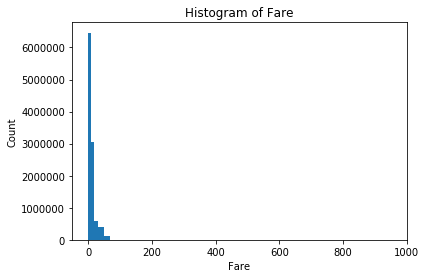

In [26]:
import matplotlib.pyplot as plt
import pylab
bins=[-50,0,10,20,30,50,70,80,90,100,150,200,250,300,800,1000,10000]
plt.hist(df['fare_amount'],bins,histtype='bar')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.xlim(-50,1000)
plt.title('Histogram of Fare')
plt.show()

# Data cleaning


Dropped NA cells

Dropped latitude and Longitude outside the New York Region i.e Latitude Range (40.495992,40.916) and Longitude Range (-74.257159,-73.699215)

Dropped Fare < 0 and Fare > 200

Dropped passenger count > 10

Dropped cells with Euclidean distance 0



In [22]:
df.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Euclidean_distance,Hour,Min,Sec,weekday,Month,Year,distance,Hour_rate
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0.009436,17.0,26.0,21.0,0,6,2009,0.640527,17.439167
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,0.079696,16.0,52.0,16.0,1,1,2010,5.250993,16.871111
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0.013674,0.0,35.0,0.0,3,8,2011,0.863464,0.583333
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,0.025340,4.0,30.0,42.0,5,4,2012,1.739493,4.511667
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,0.019470,7.0,51.0,0.0,1,3,2010,1.242295,7.850000


# Pearson Correlation

Correlation is calcualted for the requested things. 

 


In [20]:
#pre-processing done
import scipy.stats as sc
A=sc.pearsonr(df.Euclidean_distance, df.fare_amount)
B=sc.pearsonr(df.Hour_rate, df.distance)
C=sc.pearsonr(df.Hour_rate, df.fare_amount)
D= sc.pearsonr(df.distance, df.fare_amount)
print("pearson_correlation of entire data",A,B,C,D)

pearson_correlation of entire data (0.889261602906746, 0.0) (-0.02992658338056006, 0.0) (-0.017581156528025905, 0.0) (0.8815326938132544, 0.0)


In [25]:
print("Correlation for Euclidean distance and fare_amount", D[0])
print("Correlation for Euclidean distance and Time of the day", B[0])
print("Correlation for Time of the day and fare_amount", C[0])
print("Correlation for distance and fare_amount", A[0])

Correlation for Euclidean distance and fare_amount 0.8815326938132544
Correlation for Euclidean distance and Time of the day -0.02992658338056006
Correlation for Hour_rate and fare_amount -0.017581156528025905
Correlation for distance and fare_amount 0.889261602906746


# Visualizing the relation between the variables
Distance and fare are highly correlated with the value 0.881. 

Distance and Time of the day are negatively correlated with -0.029.

Fare and Time of the day are negatively correlated with -0.017.


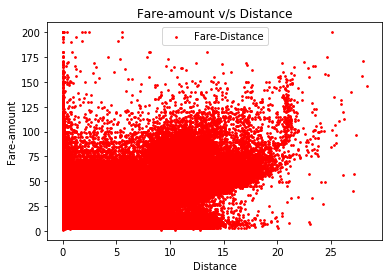

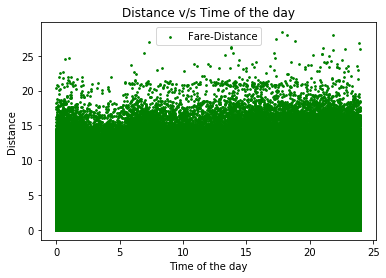

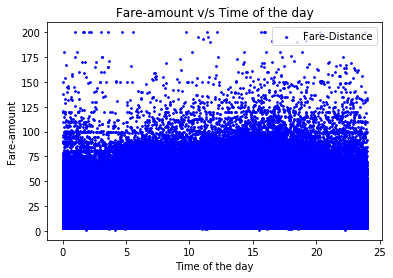

In [28]:
#Visualisation for the question 3
plt.scatter(df.distance, df.fare_amount, s=3, c='r', label='Fare-Distance')
# plt.scatter(subset_b.col1, subset_b.col2, s=60, c='r', label='col3 <= 300') 
plt.legend()
plt.ylabel('Fare-amount')
plt.xlabel('Distance')
plt.title('Fare-amount v/s Distance')
plt.show()

# plt.scatter(df.Euclidean_distance, df.fare_amount, s=3, c='y', label='Fare-Distance')
# # plt.scatter(subset_b.col1, subset_b.col2, s=60, c='r', label='col3 <= 300') 
# plt.legend()
# plt.ylabel('Fare-amount')
# plt.xlabel('Euclidean_Distance')
# plt.title('Fare-amount v/s Distance')
# plt.show()

plt.scatter(df.Hour_rate, df.distance, s=3, c='g', label='Fare-Distance')
# plt.scatter(subset_b.col1, subset_b.col2, s=60, c='r', label='col3 <= 300') 
plt.xlabel('Time of the day')
plt.ylabel('Distance')
plt.legend()
plt.title('Distance v/s Time of the day')
plt.show()

plt.scatter(df.Hour_rate, df.fare_amount, s=3, c='b', label='Fare-Distance')
# plt.scatter(subset_b.col1, subset_b.col2, s=60, c='r', label='col3 <= 300') 
plt.legend()
plt.xlabel('Time of the day')
plt.ylabel('Fare-amount')
plt.title('Fare-amount v/s Time of the day')
plt.show()

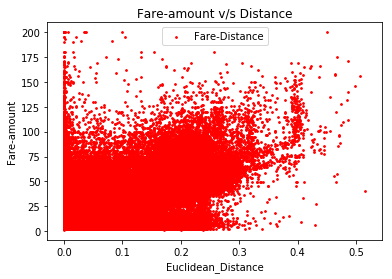

In [40]:
plt.scatter(df.Euclidean_distance, df.fare_amount, s=3, c='r', label='Fare-Distance')
# plt.scatter(subset_b.col1, subset_b.col2, s=60, c='r', label='col3 <= 300') 
plt.legend()
plt.ylabel('Fare-amount')
plt.xlabel('Euclidean_Distance')
plt.title('Fare-amount v/s Distance')
plt.show()

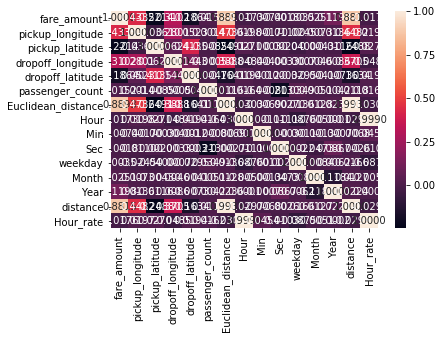

In [27]:
import seaborn as sns
sns.heatmap(df.drop(['key'],axis=1).corr(),annot=True,fmt="0.4f")
plt.show()

# Exciting plot 
I have added Year, Month, Hour, Weekday, Distance as a part of 7. 

The dataset think reveals very interesting features. 

I have presented below with the plots.


In [29]:
df.Year.describe()

count    1.060482e+07
mean     2.011744e+03
std      1.866695e+00
min      2.009000e+03
25%      2.010000e+03
50%      2.012000e+03
75%      2.013000e+03
max      2.015000e+03
Name: Year, dtype: float64

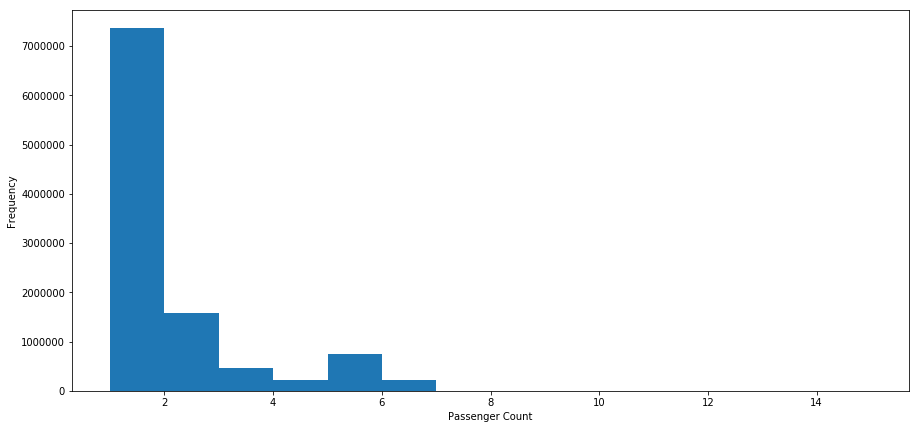

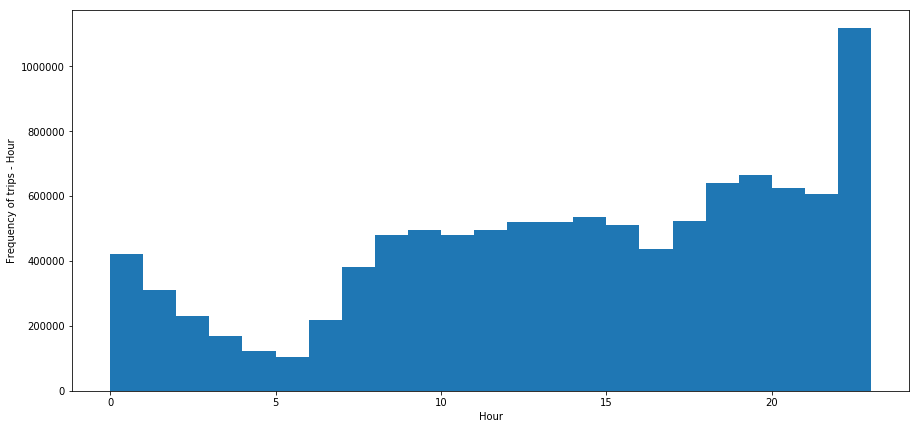

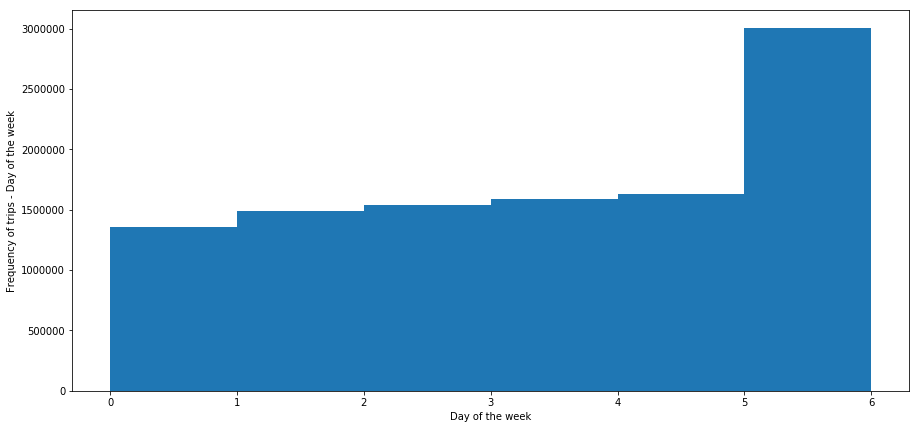

In [30]:
# Interesting observations which you can check from the data
# Passenger count v/s Frequency of trips
# Rush hour trips v/s Non Rush hour trips
# Weekday trips v/s Weekend trips
# This clearly shows that New York has night life or (late hours at work) as it has so much traffic/more trips at night.

bins=[]
for i in range(15):
    bins.append(i+1)
plt.figure(figsize=(15,7))
plt.hist(df['passenger_count'], bins)
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(15,7))
bins=[]
for i in range(24):
    bins.append(i)
plt.hist(df['Hour'], bins)
plt.xlabel('Hour')
plt.ylabel('Frequency of trips - Hour')
plt.show()


bins=[]
for i in range(7):
    bins.append(i)
plt.figure(figsize=(15,7))
plt.hist(df['weekday'], bins)
plt.xlabel('Day of the week')
plt.ylabel('Frequency of trips - Day of the week')
plt.show()


bins=[]
for i in range(12):
    bins.append(i+1)
plt.figure(figsize=(15,7))
plt.hist(df['Month'], bins)
plt.xlabel('Month')
plt.ylabel('Frequency of trips - Month')
plt.show()


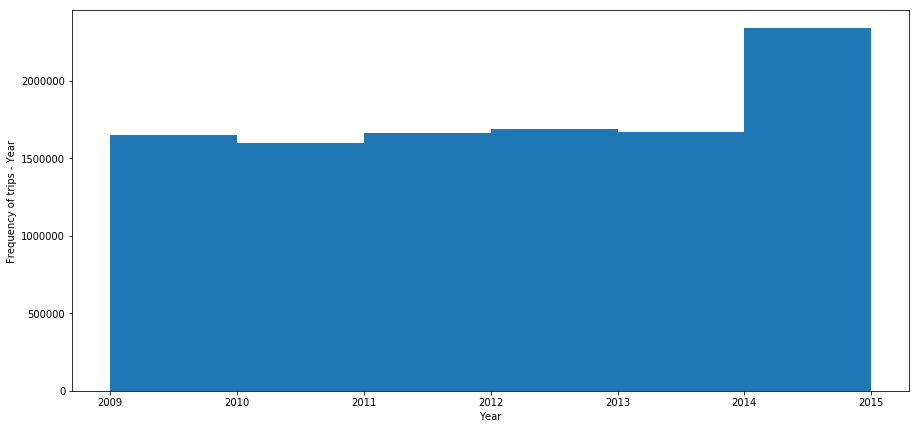

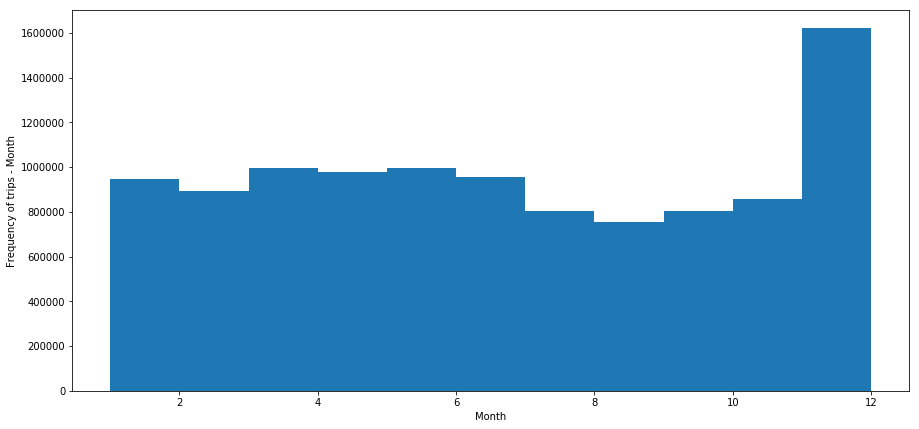

In [31]:
bins=[]
for i in range(2009,2016):
    bins.append(i)
plt.figure(figsize=(15,7))
plt.hist(df['Year'], bins)
plt.xlabel('Year')
plt.ylabel('Frequency of trips - Year')
plt.show()



#  Interesting observations

Based on the plots, you can see that there is night life or Late office work style in New York City.

In the month of december, there are too many trips.

This might be because of the holiday season and tourists might have come to New York from all over the world.

Lot many trips in weekends because of tourists and holidays.

Particularly in the year 2015, there are lot number of trips than any other year in our data base.

Weather implication on the number of the trips. 


# Additional Features Generated from the data set

I have generated the following features:

1)Day of the Week

2)Month of the year

3)Year

4)Time of the day


# Linear Regression

In [32]:
from sklearn.model_selection import train_test_split, cross_val_score #set splitting and validation
from sklearn.linear_model import LinearRegression 

X = df.drop(['key','fare_amount'],axis=1)
y = df['fare_amount']

X_train,X_test,Y_train,Y_test =train_test_split(X,y, test_size=0.2)

#Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, Y_train)
Y_pred_lin = linreg.predict(X_test)
linreg.score(X_train, Y_train)


0.8050426181483947

In [37]:
import numpy as np
from sklearn.metrics import mean_squared_error
print("Root mean Square Error on the test data", np.sqrt(mean_squared_error(Y_test, Y_pred_lin)))

Root mean Square Error on the test data 4.141296300685397


In [39]:
print(linreg.get_params())

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'normalize': False}


In [41]:
linreg_normalize = LinearRegression()
linreg_normalize.fit(X_train, Y_train)
Y_pred_lin_norm = linreg_normalize.predict(X_test)
linreg_normalize.score(X_train, Y_train)

print("Root mean Square Error on the test data", np.sqrt(mean_squared_error(Y_test, Y_pred_lin_norm)))

Root mean Square Error on the test data 4.141296300685397


In [42]:
print('Coefficients before normalize: \n', linreg.coef_)

Coefficients before normalize: 
 [ 5.77379285e+00  7.98961692e+00 -1.11358864e+01 -1.36205207e+01
  2.25874860e-02  2.51127377e+02 -7.03771525e+10 -1.17295254e+09
 -1.95492090e+07 -3.83453369e-02  6.91146851e-02  5.13336182e-01
 -5.57379961e-01  7.03771525e+10]


In [43]:
print('Coefficients after normalize: \n', linreg_normalize.coef_)

Coefficients after normalize: 
 [ 5.77379285e+00  7.98961692e+00 -1.11358864e+01 -1.36205207e+01
  2.25874860e-02  2.51127377e+02 -7.03771525e+10 -1.17295254e+09
 -1.95492090e+07 -3.83453369e-02  6.91146851e-02  5.13336182e-01
 -5.57379961e-01  7.03771525e+10]


In [44]:
X.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Euclidean_distance,Hour,Min,Sec,weekday,Month,Year,distance,Hour_rate
0,-73.844311,40.721319,-73.841610,40.712278,1,0.009436,17.0,26.0,21.0,0,6,2009,0.640527,17.439167
1,-74.016048,40.711303,-73.979268,40.782004,1,0.079696,16.0,52.0,16.0,1,1,2010,5.250993,16.871111
2,-73.982738,40.761270,-73.991242,40.750562,2,0.013674,0.0,35.0,0.0,3,8,2011,0.863464,0.583333
3,-73.987130,40.733143,-73.991567,40.758092,1,0.025340,4.0,30.0,42.0,5,4,2012,1.739493,4.511667
4,-73.968095,40.768008,-73.956655,40.783762,1,0.019470,7.0,51.0,0.0,1,3,2010,1.242295,7.850000


# Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, Y_train)
Y_pred_rf = rf.predict(X_test)
rf.score(X_train, Y_train)

# Extreme Gradient Boosting XGB

In [ ]:
import xgboost as xgb 
X = df.drop(['key','fare_amount'],axis=1)
y = df['fare_amount']
X_train = xgb.DMatrix(X, label=y)
X_test = xgb.DMatrix(tf)
params = {'max_depth':7,
          'eta':1,
          'silent':1,
          'objective':'reg:linear',
          'eval_metric':'rmse',
          'learning_rate':0.05
         }
num_rounds = 60
xb = xgb.train(params, X_train, num_rounds)
y_pred_xgb = xb.predict(X_test)
print(y_pred_xgb)

output = pd.read_csv('/Users/sriramreddy/Downloads/DSF/HW2/all/sample_submission.csv')
output['fare_amount'] = y_pred_xgb
output.to_csv('/Users/sriramreddy/Downloads/DSF/HW2/all/submission_xgb_first_11.csv', index=False)

# Adding data from external data set

In [46]:
df.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Euclidean_distance,Hour,Min,Sec,weekday,Month,Year,distance,Hour_rate
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0.009436,17.0,26.0,21.0,0,6,2009,0.640527,17.439167
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,0.079696,16.0,52.0,16.0,1,1,2010,5.250993,16.871111
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0.013674,0.0,35.0,0.0,3,8,2011,0.863464,0.583333
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,0.025340,4.0,30.0,42.0,5,4,2012,1.739493,4.511667
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,0.019470,7.0,51.0,0.0,1,3,2010,1.242295,7.850000


In [47]:
# I got to know that there is rush hour from 4pm to 8pm i.e from 16 to 20.
df.tail()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Euclidean_distance,Hour,Min,Sec,weekday,Month,Year,distance,Hour_rate
10999995,2014-06-15 04:14:00.000000100,5.0,-73.987888,40.748692,-73.979342,40.744388,1,0.009569,4.0,14.0,0.0,6,6,2014,0.537202,4.233333
10999996,2009-09-10 09:01:40.0000004,7.3,-73.987770,40.728529,-74.000935,40.720227,1,0.015564,9.0,1.0,40.0,3,9,2009,0.896852,9.027778
10999997,2011-03-10 10:55:00.000000155,11.7,-73.999375,40.731172,-73.978368,40.745368,1,0.025354,10.0,55.0,0.0,3,3,2011,1.473702,10.916667
10999998,2012-08-07 13:32:33.0000001,6.5,-73.981785,40.765401,-73.991161,40.751840,1,0.016487,13.0,32.0,33.0,1,8,2012,1.057756,13.542500
10999999,2015-01-17 02:38:03.0000001,10.5,-74.002556,40.749977,-73.967850,40.759953,1,0.036111,2.0,38.0,3.0,5,1,2015,1.942960,2.634167


In [62]:
def distance(hour):
    return 1 if 16 <= hour <= 20 else 0
c=df.head()

df["peak_hrs"] = df['Hour'].apply(distance) 
tf["peak_hrs"] = tf['Hour'].apply(distance) 

In [64]:
import xgboost as xgb 
X = df.drop(['key','fare_amount'],axis=1)
y = df['fare_amount']
X_train = xgb.DMatrix(X, label=y)
X_test = xgb.DMatrix(tf)
params = {'max_depth':12,
          'eta':1,
          'silent':1,
          'objective':'reg:linear',
          'eval_metric':'rmse',
          'learning_rate':0.05
         }
num_rounds = 90
xb = xgb.train(params, X_train, num_rounds)
y_pred_xgb = xb.predict(X_test)
print(y_pred_xgb)

submission = pd.read_csv('/Users/sriramreddy/Downloads/DSF/HW2/all/sample_submission.csv')
submission['fare_amount'] = y_pred_xgb
submission.to_csv('/Users/sriramreddy/Downloads/DSF/HW2/all/submission_xgb_final.csv', index=False)

[02:39:01] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[10.203294  10.309223   4.6396675 ... 54.00065   20.091354   6.986351 ]
